In [1]:
# SYSTEM IMPORTS
import sys
import os
import collections
import functools
import asyncio
import time
from pathlib import Path
import traceback
from multiprocessing import Pool
from functools import partial
import json
import copy

# MODULE IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import h5py
import sklearn

## Specific module imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from scipy.interpolate import interp1d, UnivariateSpline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, auc, roc_curve
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.autonotebook import tqdm

## FastAI and Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import fastai
from fastai.basic_train import *
from fastai.train import *
from fastai.metrics import *
from fastai.callbacks import *
from fastai import core, data_block
from fastai.distributed import *

from TCN.TCN.tcn import TemporalConvNet, TCN_DimensionalityReduced, TemporalSkipBlock

from utils import *

c:\users\chris\.virtualenvs\sepsis-ml-wbv6syrs\lib\site-packages\ipykernel_launcher.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# pretty display stuff
from IPython.display import display, clear_output

In [3]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [4]:
datab = fastai.basic_train.load_data(
    'C:/Users/chris/Downloads/training_cov_npy',
    'datab.pkl',
    collate_fn=pad_collate,
    pin_memory=False,
    num_workers=1,
    bs=2048
)

In [7]:
# results = []
classification_reports = []
skf = StratifiedKFold(10, random_state=42, shuffle=False)
model_outputs = []
for idx, (train_idx, test_idx) in enumerate(tqdm(skf.split(range(len(datab.test_ds.x)), np.any(datab.test_ds.y.items, axis=1).astype('int')), total=10)):
    split_ils = datab.test_ds.x.split_by_idxs(train_idx, test_idx)
    split_ils_y = datab.test_ds.y.split_by_idxs(train_idx, test_idx)
    x_train, x_valid, y_train, y_valid = split_ils.train, split_ils.valid, \
        split_ils_y.train, split_ils_y.valid
    ll = fastai.data_block.LabelLists(
        datab.path,
        train=data_block.LabelList(x_train, y_train, tfms=[]),
        valid=data_block.LabelList(x_valid, y_valid, tfms=[]),
    )
    ll.test = datab.test_ds
#     print("Loading Database", end='\t')
    datab = ll.transform([]).databunch(
        collate_fn=pad_collate,
        num_workers=0,
        pin_memory=True,
        bs=2048
    )
#     print("Done")
    net = TCN(
        40,
        336,
#         [32] * 3,
#         64,
        [32] * 9,
        2,
        0.2,
        use_skip_connections=True,
        reduce_dimensionality=False
    )
    net.load_state_dict(torch.load('prototyping/10fold-100(2)/ProtoTCN-%d_fold-best.pth' % (idx+1))['model'])
    preds, y, losses = get_preds(net.cuda(), datab.valid_dl, loss_func=nn.BCEWithLogitsLoss())
    sigmoid = nn.Sigmoid()(preds)
#     print(preds.shape, sigmoid.shape)
    thresh = 0.5
#     results.append(
#         get_normalised_utility_score(
#             y.numpy()[:, 250:],
#             (sigmoid.numpy() > thresh).astype('int')[:, 250:],
#             sigmoid.numpy()[:, 250:]
#         )
#     )
    classification_reports.append(
        classification_report(
            np.any(y.numpy()[:, 250:], axis=1),
            np.any((sigmoid.numpy() > thresh)[:, 250:], axis=1),
            labels=[False, True],
            output_dict=True
        )
    )
    model_outputs.append({
        'preds': preds,
        'y': y,
        'sigmoid': sigmoid,
        'test_indices': test_idx
    })
#     clear_output(wait=True)
#     results_df = pd.DataFrame(results, columns=["auroc", "auprc", "accuracy", "f_measure", "normalized_observed_utility"])
#     display(results_df)

c:\users\chris\.virtualenvs\sepsis-ml-wbv6syrs\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [8]:
for report in classification_reports:
    display(pd.DataFrame(report))

,False,True,accuracy,macro avg,weighted avg
precision,0.968913,0.844660,0.962568,0.906787,0.959888
recall,0.991446,0.593857,0.962568,0.792651,0.962568
f1-score,0.980050,0.697395,0.962568,0.838722,0.959520
support,3741.000000,293.000000,0.962568,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.970114,0.711462,0.953892,0.840788,0.951327
recall,0.980487,0.614334,0.953892,0.797410,0.953892
f1-score,0.975273,0.659341,0.953892,0.817307,0.952326
support,3741.000000,293.000000,0.953892,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.970357,0.810811,0.961577,0.890584,0.958769
recall,0.988773,0.614334,0.961577,0.801554,0.961577
f1-score,0.979478,0.699029,0.961577,0.839254,0.959109
support,3741.000000,293.000000,0.961577,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.934184,0.789474,0.932821,0.861829,0.923673
recall,0.997862,0.102389,0.932821,0.550125,0.932821
f1-score,0.964974,0.181269,0.932821,0.573121,0.908051
support,3741.000000,293.000000,0.932821,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.969976,0.759494,0.95761,0.864735,0.954636
recall,0.984759,0.612245,0.95761,0.798502,0.957610
f1-score,0.977312,0.677966,0.95761,0.827639,0.955495
support,3740.000000,294.000000,0.95761,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.976849,0.750000,0.961329,0.863425,0.960316
recall,0.981551,0.704082,0.961329,0.842816,0.961329
f1-score,0.979194,0.726316,0.961329,0.852755,0.960765
support,3740.000000,294.000000,0.961329,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.966026,0.694915,0.950161,0.830471,0.946329
recall,0.980749,0.559727,0.950161,0.770238,0.950161
f1-score,0.973332,0.620038,0.950161,0.796685,0.947665
support,3740.000000,293.000000,0.950161,4033.000000,4033.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.962838,0.810811,0.955864,0.886824,0.951793
recall,0.990642,0.511945,0.955864,0.751294,0.955864
f1-score,0.976542,0.627615,0.955864,0.802078,0.951192
support,3740.000000,293.000000,0.955864,4033.000000,4033.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.967403,0.737991,0.954376,0.852697,0.950736
recall,0.983957,0.576792,0.954376,0.780375,0.954376
f1-score,0.975610,0.647510,0.954376,0.811560,0.951773
support,3740.000000,293.000000,0.954376,4033.000000,4033.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.970232,0.759494,0.957848,0.864863,0.954922
recall,0.984759,0.614334,0.957848,0.799547,0.957848
f1-score,0.977442,0.679245,0.957848,0.828343,0.955777
support,3740.000000,293.000000,0.957848,4033.000000,4033.000000


In [9]:
report_dfs = [pd.DataFrame(report) for report in classification_reports]
report_dfs_np = np.array([report.to_numpy() for report in report_dfs])
report_mean, report_std = report_dfs_np.mean(axis=0), report_dfs_np.std(axis=0)

In [10]:
report_df = pd.concat(report_dfs, join='inner') \
.rename_axis('score_type') \
.reset_index() \
.groupby('score_type') \
.agg(['mean', lambda x: 1.96 * x.std() / np.sqrt(len(x))]) \
.rename(columns={'<lambda_0>': '95% CI'})
report_df.loc[:'recall'] = report_df.loc[:'recall'] * 100

In [11]:
report_df

False                  True              accuracy            \
                   mean    95% CI        mean     95% CI       mean    95% CI   
score_type                                                                      
f1-score      97.592058  0.271053   62.157231   9.805038  95.480462  0.535896   
precision     96.568918  0.721354   76.691118   2.914386  95.480462  0.535896   
recall        98.649843  0.347024   55.040398  10.217311  95.480462  0.535896   
support     3740.400000  0.320067  293.200000   0.261333   0.954805  0.005359   

              macro avg           weighted avg            
                   mean    95% CI         mean    95% CI  
score_type                                                
f1-score      79.874644  5.030980    95.016726  0.953044  
precision     86.630018  1.431762    95.123902  0.660978  
recall        76.845121  4.976761    95.480462  0.535896  
support     4033.600000  0.320067  4033.600000  0.320067

In [12]:
model_outputs_cropped = copy.deepcopy(model_outputs)
for idx, fold in enumerate(tqdm(model_outputs_cropped)):
    test_indices = fold['test_indices']
    data_lengths = [datab.test_ds.x[index].len for index in test_indices]
    model_outputs_cropped[idx]['data_lengths'] = data_lengths

In [13]:
model_outputs_cropped_b = copy.deepcopy(model_outputs_cropped)

In [14]:
results_cropped = []
results_df_cropped = None
for idx, fold in enumerate(tqdm(model_outputs_cropped)):
    y_cropped, preds_cropped, sigmoids_cropped, binary_labels_cropped = [], [], [], []
    y_flat, preds_flat, sigmoid_flat = [], [], []
    for sample_idx, length in enumerate(fold['data_lengths']):
        y_cropped.append(model_outputs_cropped[idx]['y'][sample_idx][-length:].numpy())
        preds_cropped.append(model_outputs_cropped[idx]['preds'][sample_idx][-length:].numpy())
        sigmoids_cropped.append(model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:].numpy())
        binary_labels_cropped.append(
            np.array(model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:] > thresh).astype('int')
        )
        
        y_flat += model_outputs_cropped[idx]['y'][sample_idx][-length:]
        preds_flat += model_outputs_cropped[idx]['preds'][sample_idx][-length:]
        sigmoid_flat += model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:]
    model_outputs_cropped[idx]['y_cropped'] = y_cropped
    model_outputs_cropped[idx]['preds_cropped'] = preds_cropped
    model_outputs_cropped[idx]['sigmoid_cropped'] = sigmoids_cropped
    
    model_outputs_cropped[idx]['y_flat'] = np.array(y_flat)
    model_outputs_cropped[idx]['preds_flat'] = np.array(preds_flat)
    model_outputs_cropped[idx]['sigmoid_flat'] = np.array(sigmoid_flat)
    
    results_cropped.append(
        get_normalised_utility_score(
            y_cropped,
            binary_labels_cropped,
            sigmoids_cropped
        )
    )
    clear_output(wait=True)
    results_df_cropped = pd.DataFrame(results_cropped, columns=["auroc", "auprc", "accuracy", "f_measure", "normalized_observed_utility"])
    display(results_df_cropped)

,auroc,auprc,accuracy,f_measure,normalized_observed_utility
0,0.984105,0.740524,0.990027,0.644526,0.443454
1,0.984380,0.722884,0.989364,0.643643,0.467374
2,0.985649,0.748366,0.989957,0.658328,0.469125
3,0.932189,0.328916,0.982579,0.126377,0.066510
4,0.983777,0.729120,0.989981,0.661582,0.472283
5,0.989976,0.791086,0.990719,0.710171,0.552162
6,0.982706,0.638194,0.987837,0.579594,0.412084
7,0.981774,0.699965,0.988708,0.582718,0.386285
8,0.981656,0.600711,0.987354,0.552661,0.385894
9,0.986940,0.696912,0.988337,0.600838,0.436447


In [16]:
results_df_cropped.describe()

,auroc,auprc,accuracy,f_measure,normalized_observed_utility
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.979315,0.669668,0.988486,0.576044,0.409162
std,0.016748,0.131589,0.002338,0.164909,0.129881
min,0.932189,0.328916,0.982579,0.126377,0.066510
25%,0.982007,0.652873,0.987962,0.580375,0.392735
50%,0.983941,0.711425,0.989036,0.622240,0.439951
75%,0.985332,0.737673,0.989975,0.654877,0.468687
max,0.989976,0.791086,0.990719,0.710171,0.552162


In [243]:
datab.valid_ds.x[9].data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [14.5000, 14.5000, 14.5000,  ..., 14.5000, 14.5000, 14.5000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-5.9300, -5.9300, -5.9300,  ..., -5.9300, -5.9300, -5.9300],
        [ 1.0000,  2.0000,  3.0000,  ..., 28.0000, 29.0000, 30.0000]],
       dtype=torch.float64)

In [5]:
from sklearn.metrics import classification_report, auc, precision_recall_curve
from sklearn.metrics import roc_curve as sk_roc_curve
from scipy import interp
sns.set()
plt.style.use('seaborn-paper')

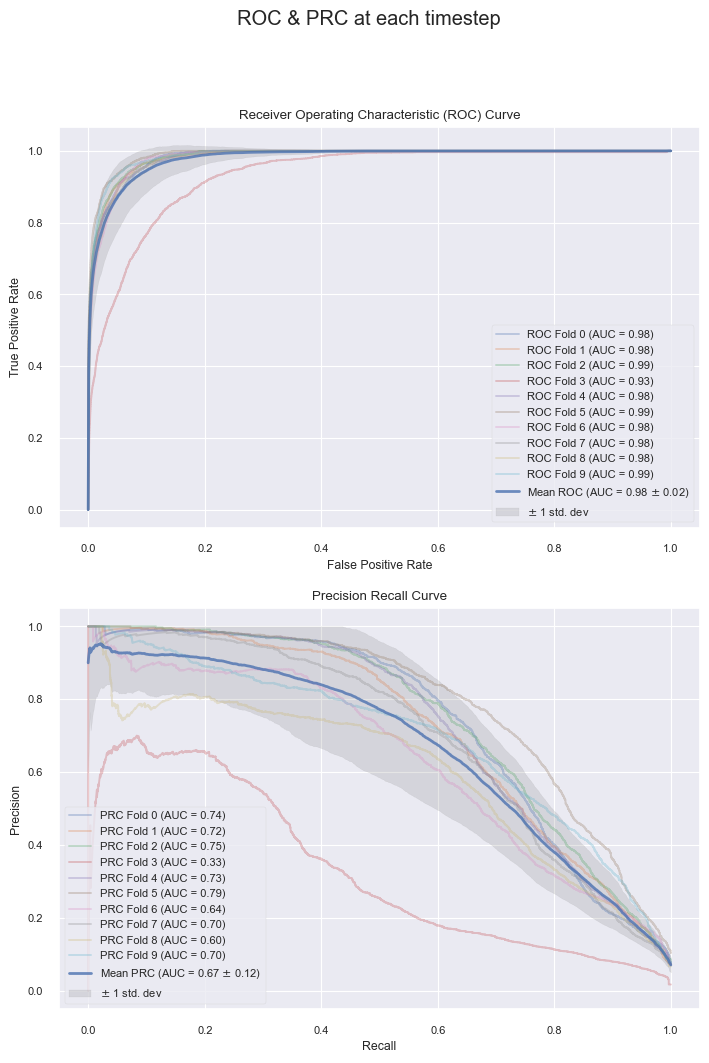

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
tprs, aurocs = [], []
tpr_threshes = []
fpr_mean = np.linspace(0, 1, 1000)
precisions, auprcs = [], []
recall_threshes = []
recall_mean = np.linspace(0, 1, 1000)
for fold_idx, fold in enumerate(tqdm(model_outputs_cropped)):
    # ROC
    fpr, tpr, tpr_thresh = sk_roc_curve(fold['y_flat'], fold['sigmoid_flat'])
    tpr_threshes.append(tpr_thresh[np.abs(tpr-0.85).argmin()])
    tpr_interp = np.interp(fpr_mean, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aurocs.append(auc(fpr, tpr))
    ax[0].plot(fpr, tpr, label="ROC Fold %d (AUC = %0.2f)" % (fold_idx, aurocs[fold_idx]), alpha=.3)
    # PRC
    precision, recall, prc_thresh = precision_recall_curve(fold['y_flat'], fold['sigmoid_flat'])
    prec_interp = np.interp(recall_mean, recall[::-1], precision[::-1])
#     prec_interp[0] = 1.0
    precisions.append(prec_interp)
    recall_threshes.append(prc_thresh[np.abs(recall-0.85).argmin()])
    auprcs.append(auc(recall, precision))
    ax[1].plot(recall, precision, label="PRC Fold %d (AUC = %0.2f)" % (fold_idx, auprcs[fold_idx]), alpha=.3)

ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Receiver Operating Characteristic (ROC) Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision Recall Curve")

# ROC
tpr_mean = np.mean(tprs, axis=0)
tpr_mean[-1] = 1.0
auroc_mean = auc(fpr_mean, tpr_mean)
auroc_std  = np.std(aurocs)
ax[0].plot(fpr_mean, tpr_mean,
           label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (auroc_mean, auroc_std),
           lw=2, alpha=.8)
tpr_std = np.std(tprs, axis=0)
ax[0].fill_between(
    fpr_mean,
    np.maximum(tpr_mean+tpr_std, 0),
    np.minimum(tpr_mean-tpr_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)
# PRC
prec_mean = np.mean(precisions, axis=0)
# prec_mean[-1] = 0.0
auprc_mean = auc(recall_mean, prec_mean)
auprc_std = np.std(auprcs)
ax[1].plot(recall_mean, prec_mean,
           label=r"Mean PRC (AUC = %0.2f $\pm$ %0.2f)" % (auprc_mean, auprc_std),
           lw=2, alpha=.8)
prec_std = np.std(precisions, axis=0)
ax[1].fill_between(
    recall_mean,
    np.maximum(prec_mean-prec_std, 0),
    np.minimum(prec_mean+prec_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)

fig.suptitle("ROC & PRC at each timestep")
ax[0].legend()
ax[1].legend()
plt.show()

In [42]:
tpr_threshes, recall_threshes

([0.059137672,
  0.044070657,
  0.056783326,
  0.04249861,
  0.032578297,
  0.048405938,
  0.036267117,
  0.041176565,
  0.049825583,
  0.05612391],
 [0.05895731,
  0.04390825,
  0.05677564,
  0.042456448,
  0.032510582,
  0.04832947,
  0.03624176,
  0.04096476,
  0.04952772,
  0.056114133])

In [20]:
for (idx, tpr) in enumerate(tprs):
    i = np.abs(tpr - 0.85).argmin()
    print(tprs[idx][i])

0.8504273504273504
0.8489620615604867
0.8515625
0.8496965369510889
0.8486888731396173
0.850124599501602
0.8474945533769063
0.8488538681948424
0.8518518518518519
0.8456254519161244


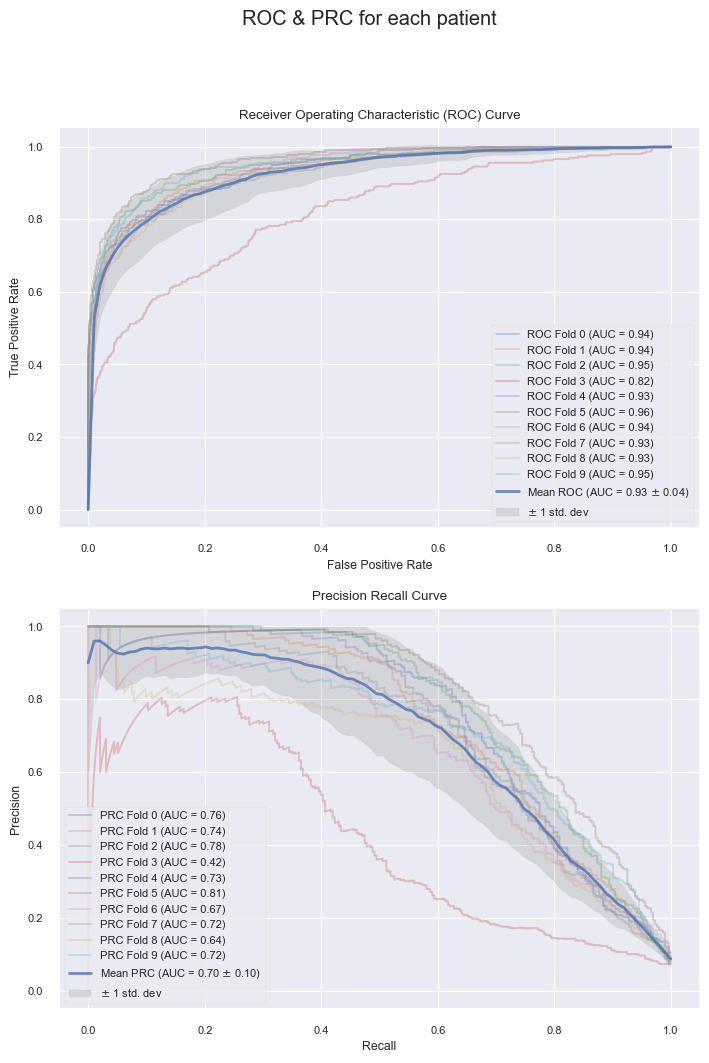

In [21]:
fig2, ax2 = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
tprs, aurocs = [], []
tpr_threshes = []
fpr_mean = np.linspace(0, 1, 100)
precisions, auprcs = [], []
recall_threshes = []
recall_mean = np.linspace(0, 1, 100)
for fold_idx, fold in enumerate(tqdm(model_outputs_cropped)):
    # ROC
    fpr, tpr, roc_threshes = sk_roc_curve(
        [np.any(label).astype('int') for label in fold['y_cropped']],
        [np.max(sigmoid) for sigmoid in fold['sigmoid_cropped']]
    )
    tpr_interp = np.interp(fpr_mean, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aurocs.append(auc(fpr, tpr))
    tpr_threshes.append(roc_threshes[np.abs(tpr - 0.85).argmin()])
    ax2[0].plot(fpr, tpr, label="ROC Fold %d (AUC = %0.2f)" % (fold_idx, aurocs[fold_idx]), alpha=.3)
    # PRC
    precision, recall, prc_threshes = precision_recall_curve(
        [np.any(label).astype('int') for label in fold['y_cropped']],
        [np.max(sigmoid) for sigmoid in fold['sigmoid_cropped']]
    )
    prec_interp = np.interp(recall_mean, recall[::-1], precision[::-1])
#     prec_interp[0] = 1.0
    precisions.append(prec_interp)
    auprcs.append(auc(recall, precision))
    recall_threshes.append(prc_threshes[np.abs(recall - 0.85).argmin()])
    ax2[1].plot(recall, precision, label="PRC Fold %d (AUC = %0.2f)" % (fold_idx, auprcs[fold_idx]), alpha=.3)

ax2[0].set_xlabel("False Positive Rate")
ax2[0].set_ylabel("True Positive Rate")
ax2[0].set_title("Receiver Operating Characteristic (ROC) Curve")
ax2[1].set_xlabel("Recall")
ax2[1].set_ylabel("Precision")
ax2[1].set_title("Precision Recall Curve")
# ROC
tpr_mean = np.mean(tprs, axis=0)
tpr_mean[-1] = 1.0
auroc_mean = auc(fpr_mean, tpr_mean)
auroc_std  = np.std(aurocs)
ax2[0].plot(fpr_mean, tpr_mean,
           label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (auroc_mean, auroc_std),
           lw=2, alpha=.8)
tpr_std = np.std(tprs, axis=0)
ax2[0].fill_between(
    fpr_mean,
    np.maximum(tpr_mean+tpr_std, 0),
    np.minimum(tpr_mean-tpr_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)
# PRC
prec_mean = np.mean(precisions, axis=0)
# prec_mean[-1] = 0.0
auprc_mean = auc(recall_mean, prec_mean)
auprc_std = np.std(auprcs)
ax2[1].plot(recall_mean, prec_mean,
           label=r"Mean PRC (AUC = %0.2f $\pm$ %0.2f)" % (auprc_mean, auprc_std),
           lw=2, alpha=.8)
prec_std = np.std(precisions, axis=0)
ax2[1].fill_between(
    recall_mean,
    np.maximum(prec_mean-prec_std, 0),
    np.minimum(prec_mean+prec_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)

fig2.suptitle("ROC & PRC for each patient")
ax2[0].legend()
ax2[1].legend()
plt.show()

In [22]:
_85sens_threshes = np.mean(list(zip(tpr_threshes, recall_threshes)), axis=1)

In [23]:
_85sens_classification_reports = []
for fold_idx, fold in enumerate(tqdm(model_outputs_cropped)):
    _85sens_classification_reports.append(classification_report(
        [np.any(y) for y in fold['y_cropped']],
        [np.any(sigmoid > _85sens_threshes[fold_idx]) for sigmoid in fold['sigmoid_cropped']],
        labels=[False, True],
        output_dict=True
    ))

In [24]:
_85sens_report_dfs = [pd.DataFrame(report) for report in _85sens_classification_reports]
_85sens_report_dfs_np = np.array([report.to_numpy() for report in _85sens_report_dfs])
_85sens_report_mean, _85sens_report_std = _85sens_report_dfs_np.mean(axis=0), _85sens_report_dfs_np.std(axis=0)

In [25]:
_85sens_report_df = pd.concat(_85sens_report_dfs, join='inner') \
.rename_axis('score_type') \
.reset_index() \
.groupby('score_type') \
.agg(['mean', lambda x: 1.96 * x.std() / np.sqrt(len(x))]) \
.rename(columns={'<lambda_0>': '95% CI'})
_85sens_report_df.loc[:'recall'] = _85sens_report_df.loc[:'recall'] * 100

In [26]:
_85sens_report_df

False                  True             accuracy            \
                   mean    95% CI        mean    95% CI       mean    95% CI   
score_type                                                                     
f1-score      90.676260  3.963868   47.135667  6.379041  84.468097  5.559826   
precision     98.604722  0.129332   33.315095  5.834356  84.468097  5.559826   
recall        84.427206  5.995139   84.993151  0.013349  84.468097  5.559826   
support     3740.400000  0.320067  293.200000  0.261333   0.844681  0.055598   

              macro avg           weighted avg            
                   mean    95% CI         mean    95% CI  
score_type                                                
f1-score      68.905964  5.090073    87.511501  4.111394  
precision     65.959909  2.973065    93.859186  0.529491  
recall        84.710178  2.999326    84.468097  5.559826  
support     4033.600000  0.320067  4033.600000  0.320067

In [276]:
bce_weights = []
for fold in tqdm(model_outputs):
    bce_weights.append(fold['y'].numpy())
bce_weights = np.concatenate(bce_weights, axis=0)
n = len(bce_weights)
bce_weights = n/np.sum(bce_weights, axis=0)
bce_weights[bce_weights==np.inf] = n
bce_weights[-10:]

c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


array([21.570053, 15.13546 , 13.846893, 13.827906, 13.804244, 13.804244, 13.794802, 13.794802, 13.780663, 13.757162],
      dtype=float32)

In [30]:
results_cropped = []
results_df_cropped = None
for idx, fold in enumerate(tqdm(model_outputs_cropped)):
    thresh = _85sens_threshes[idx]
    y_cropped, preds_cropped, sigmoids_cropped, binary_labels_cropped = [], [], [], []
    y_flat, preds_flat, sigmoid_flat = [], [], []
    for sample_idx, length in enumerate(fold['data_lengths']):
        y_cropped.append(model_outputs_cropped[idx]['y'][sample_idx][-length:].numpy())
        preds_cropped.append(model_outputs_cropped[idx]['preds'][sample_idx][-length:].numpy())
        sigmoids_cropped.append(model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:].numpy())
        binary_labels_cropped.append(
            np.array(model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:] > thresh).astype('int')
        )
        
        y_flat += model_outputs_cropped[idx]['y'][sample_idx][-length:]
        preds_flat += model_outputs_cropped[idx]['preds'][sample_idx][-length:]
        sigmoid_flat += model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:]
    model_outputs_cropped[idx]['y_cropped'] = y_cropped
    model_outputs_cropped[idx]['preds_cropped'] = preds_cropped
    model_outputs_cropped[idx]['sigmoid_cropped'] = sigmoids_cropped
    
    model_outputs_cropped[idx]['y_flat'] = np.array(y_flat)
    model_outputs_cropped[idx]['preds_flat'] = np.array(preds_flat)
    model_outputs_cropped[idx]['sigmoid_flat'] = np.array(sigmoid_flat)
    
    results_cropped.append(
        get_normalised_utility_score(
            y_cropped,
            binary_labels_cropped,
            sigmoids_cropped
        )
    )
    clear_output(wait=True)
    results_df_cropped = pd.DataFrame(results_cropped, columns=["auroc", "auprc", "accuracy", "f_measure", "normalized_observed_utility"])
    display(results_df_cropped)

,auroc,auprc,accuracy,f_measure,normalized_observed_utility
0,0.984105,0.740524,0.975542,0.539782,0.665572
1,0.984380,0.722884,0.977157,0.552612,0.658690
2,0.985649,0.748366,0.982069,0.607566,0.653091
3,0.932189,0.328916,0.901908,0.218573,0.598009
4,0.983777,0.729120,0.974982,0.534789,0.662782
5,0.989976,0.791086,0.985636,0.668256,0.690594
6,0.982706,0.638194,0.970165,0.477902,0.637047
7,0.981774,0.699965,0.972122,0.505145,0.656885
8,0.981656,0.600711,0.970841,0.486584,0.652728
9,0.986940,0.696912,0.981743,0.606632,0.674046


In [31]:
results_df_cropped.describe()

,auroc,auprc,accuracy,f_measure,normalized_observed_utility
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.979315,0.669668,0.969216,0.519784,0.654944
std,0.016748,0.131589,0.024199,0.121470,0.024491
min,0.932189,0.328916,0.901908,0.218573,0.598009
25%,0.982007,0.652873,0.971161,0.491224,0.652819
50%,0.983941,0.711425,0.975262,0.537286,0.657787
75%,0.985332,0.737673,0.980597,0.593127,0.664875
max,0.989976,0.791086,0.985636,0.668256,0.690594


c:\users\chris\.virtualenvs\sepsis-ml-wbv6syrs\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


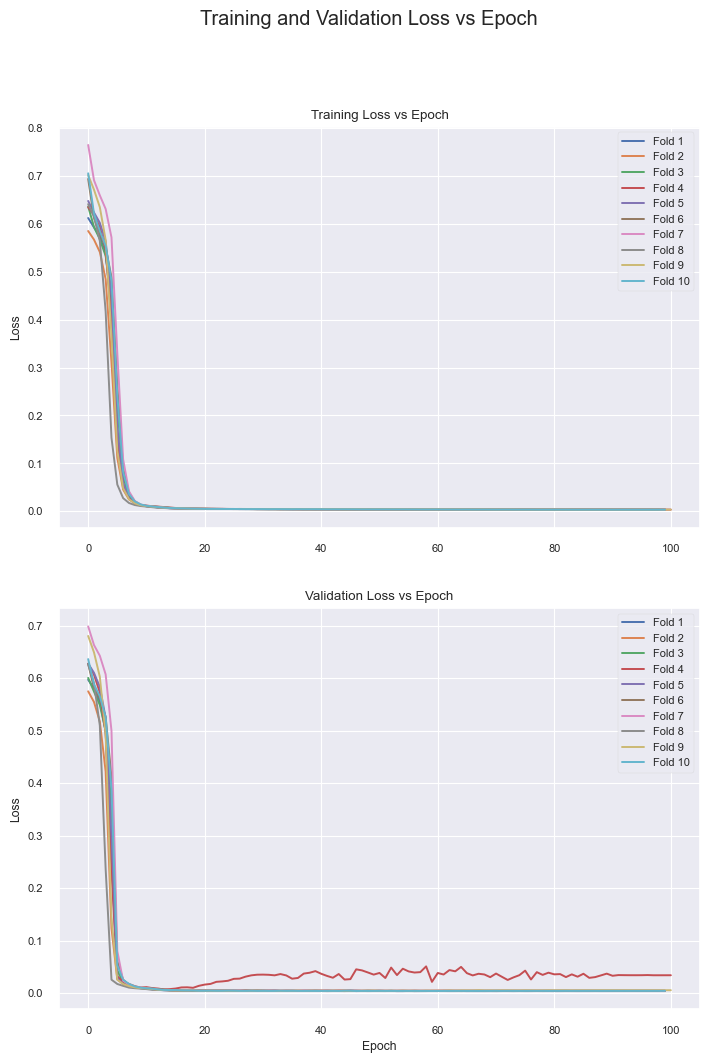

In [6]:
fig3, ax3 = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
for i in tqdm(range(10)):
    plot_df = pd.read_csv('prototyping/%d-fold_history.csv' % (i+1))
    ax3[0].plot(plot_df['train_loss'], label="Fold %d" % (i+1))
    ax3[1].plot(plot_df['valid_loss'], label="Fold %d" % (i+1))
ax3[0].set_title('Training Loss vs Epoch')
ax3[1].set_title('Validation Loss vs Epoch')
ax3[1].set_xlabel('Epoch')
ax3[0].set_ylabel('Loss')
ax3[1].set_ylabel('Loss')
ax3[0].legend()
ax3[1].legend()
fig3.suptitle("Training and Validation Loss vs Epoch")
fig3.show()